In [13]:
# import packages

import seaborn as sns
import pandas as pd
import matplotlib
import mlxtend.frequent_patterns
from matplotlib import pyplot as plt
from pathlib import Path
from mlxtend.frequent_patterns import apriori, fpgrowth
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [15]:
# set file location

file_loc = Path('/Users/maccy/Downloads')
print("file location exists:", file_loc.is_dir())

file location exists: True


In [19]:
# import dataset 

df = pd.read_csv(file_loc/'titanic.csv')
df

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [22]:
# find out number of rows and columns

df.shape

(891, 16)

In [44]:
# find null values

nulls = df.isnull()
print("These are the features with null values, and the count of null values in each.")
nulls.sum()[nulls.sum() > 0]

These are the features with null values, and the count of null values in each.


age            177
embarked         2
deck           688
embark_town      2
dtype: int64

In [46]:
# Impute missing 'age' values based on another ('who') column, and check

category_means = df.groupby('who')['age'].transform('mean')
df1 = df
df1['age'].fillna(category_means, inplace=True)
df1[df1['who'] == 'child'].describe()


,Unnamed: 0,survived,pclass,age,sibsp,parch,fare
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,430.602410,0.590361,2.626506,6.369518,1.734940,1.265060,32.785795
std,287.079319,0.494757,0.619024,4.729063,1.638592,0.682255,33.466438
min,7.000000,0.000000,1.000000,0.420000,0.000000,0.000000,7.225000
25%,171.500000,0.000000,2.000000,2.000000,0.000000,1.000000,15.900000
50%,435.000000,1.000000,3.000000,5.000000,1.000000,1.000000,26.250000
75%,705.500000,1.000000,3.000000,9.500000,3.000000,2.000000,32.193750
max,875.000000,1.000000,3.000000,15.000000,5.000000,2.000000,211.337500


In [48]:
# try a quick association rule to see if there is some pattern to deck = NaN
# first we create a categories dataframe

df_categories = df1.drop(['pclass', 'sibsp', 'parch', 'Unnamed: 0', 'embarked', 'sex', 'age', 'fare', 'alive', 'adult_male'], axis=1)
df_categories

,survived,class,who,deck,embark_town,alone
0,0,Third,man,NaN,Southampton,False
1,1,First,woman,C,Cherbourg,False
2,1,Third,woman,NaN,Southampton,True
3,1,First,woman,C,Southampton,False
4,0,Third,man,NaN,Southampton,True
...,...,...,...,...,...,...
886,0,Second,man,NaN,Southampton,True
887,1,First,woman,B,Southampton,True
888,0,Third,woman,NaN,Southampton,False
889,1,First,man,C,Cherbourg,True


In [55]:
# then we encode the category columns

codes = cat_encoder.fit_transform(df_categories[['class', 'who', 'deck', 'embark_town']])
names = cat_encoder.get_feature_names_out(['class', 'who', 'deck', 'embark_town'])
encoded_df = pd.DataFrame(codes.todense(), columns = names)
encoded_df

,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [64]:
# then we clean things up a bit

df2 = pd.merge(encoded_df, df_categories[['survived', 'alone']], left_index=True, right_index=True)
df2['alone'] = df2['alone'].replace([True, False], [1,0])
df2

,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,survived,alone
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
887,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
888,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1


In [81]:
# then we do some association rule mining using apriori and print the results

results = apriori(df2, min_support = .2)
results = results[results['itemsets'].apply(lambda x: len(x)) > .2]
results = results[results['itemsets'].apply(lambda x: 'deck_nan' in x)]
results

/Users/maccy/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets


In [104]:
# let's look at a subset of the data we suspect is most closely related to deck = NaN
# we want to filter to: who = man, embark town = southampton, alone = true and class_third = true
# we want the resulting table to just show the counts of each variable after filtering

df2[ (df2['who_man'] == True) & (df2['embark_town_Southampton'] == True ) & (df2['alone'] == True ) & (df2['class_Third'] == True )][['who_man', 'embark_town_Southampton', 'alone']].sum()

who_man                    202.0
embark_town_Southampton    202.0
alone                      202.0
dtype: float64

In [112]:
# join df1 and df2 for analysis like clustering, correlation, and pca

df3 = pd.concat([df1[['age','fare']], df2], axis=1)
df3

,age,fare,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,...,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,survived,alone
0,22.0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
1,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2,26.0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1
3,35.0,53.1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
4,35.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
887,19.0,30.0000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
888,32.0,23.4500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
889,26.0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1


In [115]:
# normalize age and fare, so they don't bias our clustering and correlation

from sklearn.preprocessing import MinMaxScaler
df3[['age', 'fare']] = MinMaxScaler().fit_transform(df3[['age', 'fare']])
df3


,age,fare,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,...,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,survived,alone
0,0.271174,0.014151,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
1,0.472229,0.139136,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2,0.321438,0.015469,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1
3,0.434531,0.103644,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
4,0.434531,0.015713,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1
887,0.233476,0.058556,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
888,0.396833,0.045771,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
889,0.321438,0.058556,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1


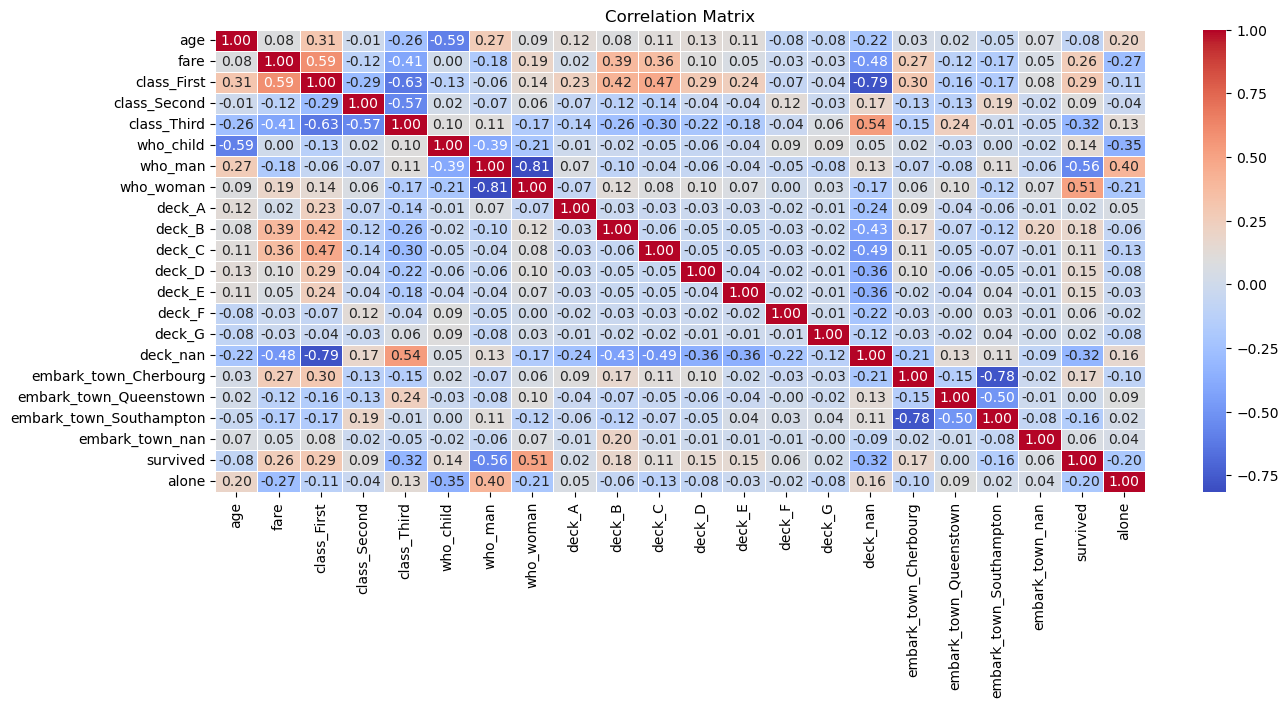

In [116]:
# discover correlations 

corr_matrix = df3.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()